# Memory Monitoring

In [1]:
# !scontrol show job $SLURM_JOB_ID

In [2]:
import psutil
import threading
import time
import IPython.display as display

# Create a dedicated display handle for monitoring
memory_output = display.display("", display_id=True)

# Global flag to stop monitoring
stop_monitoring = False
start_mem = psutil.virtual_memory().used

def monitor_memory():
    while not stop_monitoring:
        mem = psutil.virtual_memory()
        memory_output.update(f"🖥️ RAM Usage: {(mem.used - start_mem)/ 1e9:.2f} GB / {mem.total / 1e9:.2f} GB")
        time.sleep(0.1)

# Start the monitoring thread
memory_thread = threading.Thread(target=monitor_memory, daemon=True)
memory_thread.start()

'🖥️ RAM Usage: 11.77 GB / 810.76 GB'

# Import dependencies

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq

import torch
print(f'CUDA available is {torch.cuda.is_available()}')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics.pairwise import cosine_similarity
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

from scipy.optimize import curve_fit

CUDA available is True


# Data

We have vectors of genes and species present in samples.

Genes are clustered on similarity. 
We have chosen 3 different similarities for clustering: 0.9, 0.95, 0.99

The taxon data is also of variable granularity.

In [4]:
# dimention of different taxon vectors
taxons = ['s', 'g', 'f', 'c', 'o', 'p']

taxon_name = {'s': 'Species',
              'g': 'Genus',
              'f': 'Family',
              'o': 'Order',
              'c': 'Class',
              'p': 'Phylum'}

for taxon in taxons:
    schema = pq.read_schema(f'../processed_data/taxon_coverage_{taxon}.parquet')
    print(f'{taxon_name[taxon]} Vector has dimention {len(schema.names)}')

print('\n -------- \n')

# dimention of different cluster similarities
similarities = ['99', '95', '90']

for similarity in similarities:
    schema = pq.read_schema(f'../processed_data/gene_coverage_{similarity}.parquet')
    print(f'Gene similarity {similarity} Vector has dimention {len(schema.names)}')


Species Vector has dimention 4077
Genus Vector has dimention 2011
Family Vector has dimention 614
Class Vector has dimention 134
Order Vector has dimention 282
Phylum Vector has dimention 64

 -------- 

Gene similarity 99 Vector has dimention 341853
Gene similarity 95 Vector has dimention 156706
Gene similarity 90 Vector has dimention 4276


# Taxon

In [5]:
df_taxon = pd.read_parquet('../processed_data/taxon_coverage_s.parquet')

In [6]:
df_taxon

,Bifidobacterium longum,Bifidobacterium breve,Bifidobacterium bifidum,Collinsella sp022728415,Bacteroides fragilis,Bacteroides stercoris,Bacteroides caccae,Phocaeicola vulgatus,Prevotella sp900543975,Parabacteroides distasonis,...,CAG-449 sp905204225,Prevotella sp900547085,Butyricicoccus sp900547195,Gordonibacter avicola,Lachnospira sp002394205,CACZQA01 sp900758075,Collinsella sp018368345,Faecalibacterium sp905215595,Anaerococcus murdochii,Sellimonas sp904393575
ERR2835298,85.91,109.57,8.24,0.61,5.30,1.72,23.53,11.86,2.87,3.36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR12302558,63.99,113.22,18.55,0.00,66.84,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR13622751,125.85,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR15127829,419.87,55.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR12325043,109.82,5.50,31.63,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR13774526,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERR3053454,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR13774523,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR13774530,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


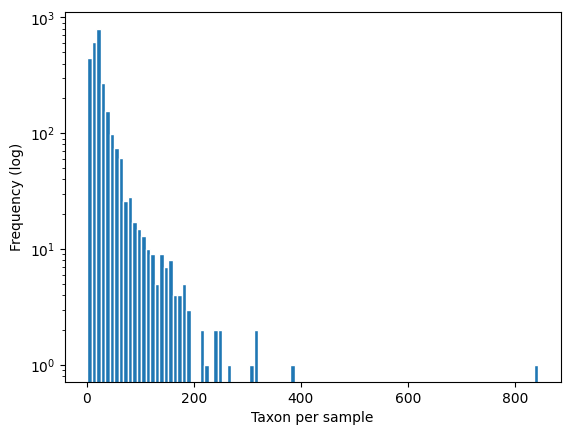

In [7]:
# taxon per Sample
count_taxon_sample = (df_taxon > 0).sum(1).sort_values(ascending=False)
plt.hist(count_taxon_sample.values, edgecolor='white', bins=100)
plt.ylabel('Frequency (log)')
plt.xlabel('Taxon per sample')
plt.yscale('log')
plt.show()

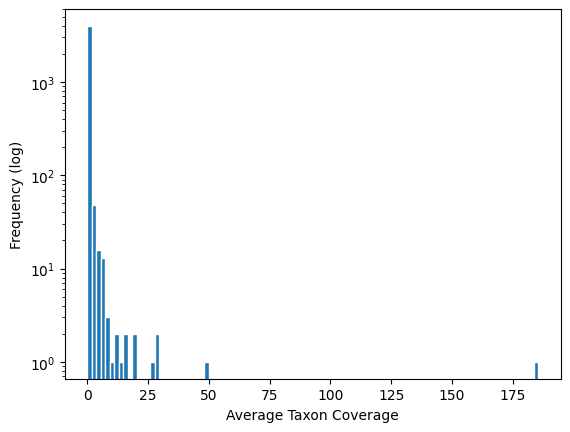

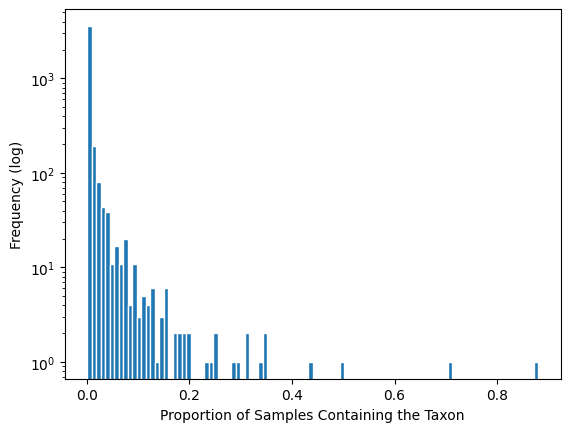

In [8]:
# Average taxon Coverage
sum_taxon_coverage = df_taxon.sum(0).sort_values(ascending=False)
plt.hist(sum_taxon_coverage.values/df_taxon.shape[0], edgecolor='white', bins=100)
plt.ylabel('Frequency (log)')
plt.xlabel('Average Taxon Coverage')
plt.yscale('log')
plt.show()

# Average taxon Count
count_taxon = (df_taxon > 0).sum(0).sort_values(ascending=False)
plt.hist(count_taxon.values / df_taxon.shape[0], edgecolor='white', bins=100)
plt.ylabel('Frequency (log)')
plt.xlabel('Proportion of Samples Containing the Taxon')
plt.yscale('log')
plt.show()

In [9]:
count_threshold = 200

print(f'# Taxon that appear in less than {count_threshold} samples: {int((count_taxon < count_threshold).sum())}')

# Taxon that appear in less than 200 samples: 3999


# Genes

In [10]:
df_genes = pd.read_parquet('../processed_data/gene_coverage_95.parquet')
df_genes = df_genes.set_index("Sample")

# force same order 
df_genes.loc[df_taxon.index]

,MGYG000134667_133_3,MGYG000220072_86_12,MGYG000122362_158_6,MGYG000056936_65_7,MGYG000209784_296_4,MGYG000191209_8_1,MGYG000284963_88_5,MGYG000242692_2_6,MGYG000191209_8_2,MGYG000130054_219_6,...,MGYG000096137_1_250,MGYG000281342_102_2,MGYG000056305_258_1,MGYG000137704_152_2,MGYG000034987_212_1,MGYG000242692_2_1,MGYG000209784_296_1,MGYG000281342_102_3,MGYG000130054_219_1,MGYG000148864_43_1
ERR2835298,0.0,0.000000,0.000000,2.10526,5.389450,0.0,0.0,7.12261,0.0,48.982101,...,12.6247,81.782700,113.648003,10.357800,0.0,0.0,0.000000,4.953590,0.000000,2.533830
SRR12302558,0.0,0.000000,39.028400,0.00000,4.488450,0.0,0.0,3.39846,0.0,25.017900,...,0.0000,0.000000,51.579201,19.398399,0.0,0.0,0.188406,0.177514,0.278075,2.283210
SRR13622751,0.0,0.000000,0.000000,0.00000,1.069310,0.0,0.0,0.00000,0.0,28.487400,...,0.0000,0.000000,273.697998,45.356800,0.0,0.0,0.310559,0.028297,0.000000,3.310770
SRR15127829,0.0,0.000000,40.208000,0.00000,8.198020,0.0,0.0,1.15709,0.0,139.404999,...,0.0000,0.000000,62.629299,147.570007,0.0,0.0,0.000000,0.625354,3.219250,7.378450
SRR12325043,0.0,0.000000,131.123001,0.00000,0.000000,0.0,0.0,0.00000,0.0,45.057301,...,0.0000,0.000000,21.075701,77.250000,0.0,0.0,15.963900,0.000000,0.000000,0.375940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR13774526,0.0,6.201950,0.000000,0.00000,0.000000,0.0,0.0,0.00000,0.0,27.523300,...,0.0000,147.785004,62.789101,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.756892
ERR3053454,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.00000,0.0,0.000000,...,0.0000,9.971480,2.117190,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
SRR13774523,0.0,0.888235,0.000000,0.00000,0.000000,0.0,0.0,0.00000,0.0,3.788520,...,0.0000,9.502460,3.809890,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
SRR13774530,0.0,30.547100,0.000000,0.00000,0.000000,0.0,0.0,0.00000,0.0,143.992996,...,0.0000,0.000000,686.888977,268.356995,0.0,0.0,0.000000,0.000000,0.000000,1.478700


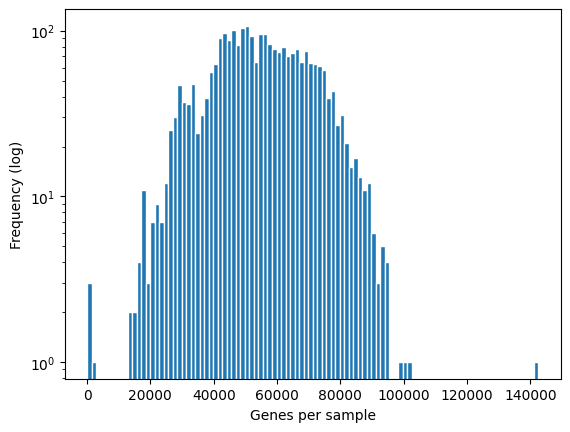

In [11]:
# Genes per Sample
count_genes_sample = (df_genes > 0).sum(1).sort_values(ascending=False)
plt.hist(count_genes_sample.values, edgecolor='white', bins=100)
plt.ylabel('Frequency (log)')
plt.xlabel('Genes per sample')
plt.yscale('log')
plt.show()

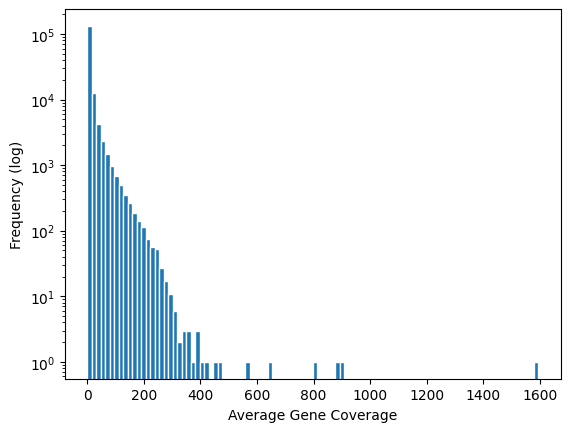

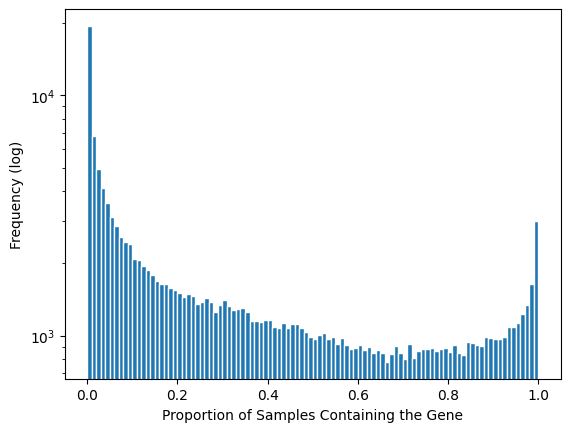

In [12]:
# Average Gene Coverage
sum_gene_coverage = df_genes.sum(0).sort_values(ascending=False)
plt.hist(sum_gene_coverage.values/df_genes.shape[0], edgecolor='white', bins=100)
plt.ylabel('Frequency (log)')
plt.xlabel('Average Gene Coverage')
plt.yscale('log')
plt.show()

# Average Gene Count
count_genes = (df_genes > 0).sum(0).sort_values(ascending=False)
plt.hist(count_genes.values / df_genes.shape[0], edgecolor='white', bins=100)
plt.ylabel('Frequency (log)')
plt.xlabel('Proportion of Samples Containing the Gene')
plt.yscale('log')
plt.show()

In [13]:
count_threshold = 200

print(f'# Genes that appear in less than {count_threshold} samples: {int((count_genes < count_threshold).sum())}')

# Genes that appear in less than 200 samples: 45826


# Useless Data

In [14]:
print(f'{(count_genes==0).sum()} genes never show up')
print(f'{(count_taxon==0).sum()} taxon never show up')
print('\n')
print(f'{(df_taxon.sum(1)==0).sum()} samples containt no taxon present')
print(f'{(df_genes.sum(1)==0).sum()} samples containt no genes present')
print('\n')
print(f'{(count_genes==df_genes.shape[0]).sum()} genes always show up')
print(f'{(count_taxon==df_taxon.shape[0]).sum()} taxon always show up') # bifidus infantis should show up on all samples (and it does!)

2074 genes never show up
0 taxon never show up


0 samples containt no taxon present
0 samples containt no taxon present


0 genes always show up
0 taxon always show up


# Sparsity

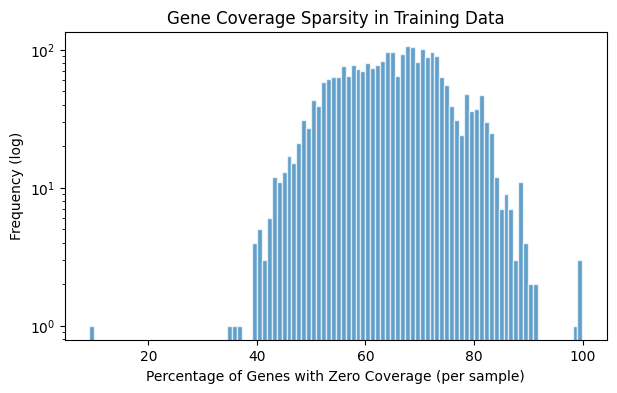

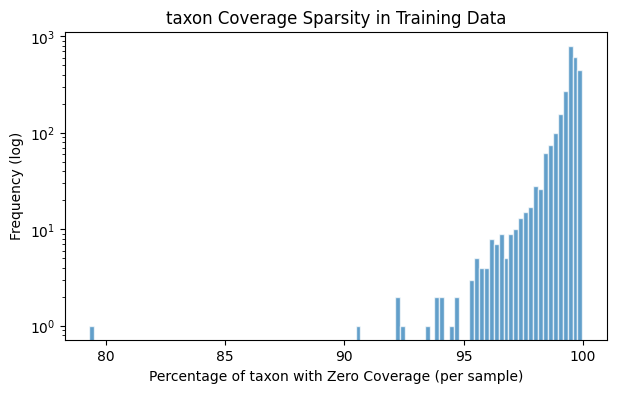

In [15]:
# Gene Sparsity per Sample
gene_sparsity = (df_genes == 0).sum(axis=1) / df_genes.shape[1] * 100

plt.figure(figsize=(7, 4))
plt.hist(gene_sparsity.values, bins=100, edgecolor='white', alpha=0.7)
plt.xlabel("Percentage of Genes with Zero Coverage (per sample)")
plt.ylabel("Frequency (log)")
plt.yscale("log")  # Log scale for better visibility
plt.title("Gene Coverage Sparsity in Training Data")
plt.show()

# taxon Sparsity per Sample
taxon_sparsity = (df_taxon == 0).sum(axis=1) / df_taxon.shape[1] * 100  # Percentage of zero taxon per sample

plt.figure(figsize=(7, 4))
plt.hist(taxon_sparsity.values, bins=100, edgecolor='white', alpha=0.7)
plt.xlabel("Percentage of taxon with Zero Coverage (per sample)")
plt.ylabel("Frequency (log)")
plt.yscale("log")  # Log scale for better visibility
plt.title("taxon Coverage Sparsity in Training Data")
plt.show()

# Core Genes

### Gene Occurrence

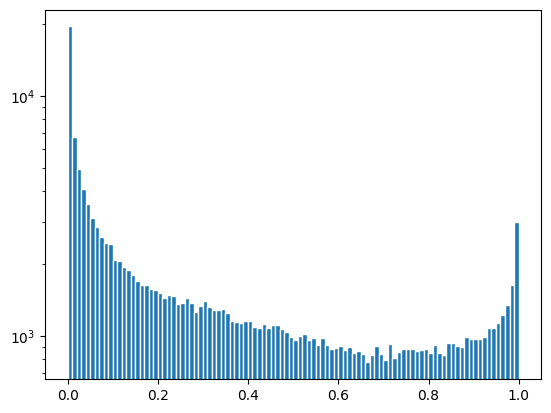

In [16]:
max((df_genes > 0).sum(0))/df_genes.shape[0]

plt.hist((df_genes>0).sum(0)/df_genes.shape[0], bins=100, edgecolor='white')
plt.yscale('log')
plt.show()

### Co-Occurrence (Gene and Taxon)

$$
M_{ij} = \frac{\sum_k S_{ki} G_{kj}}{\min(N_i, N_j)}
$$

where:

$$
S \in \{0,1\}^{n_{\text{samples}} \times n_{\text{taxon}_f}},
$$
$$
G \in \{0,1\}^{n_{\text{samples}} \times n_{\text{genes}_f}}
$$

$$
N_i = \sum_k S_{ki}, \quad N_j = \sum_k G_{kj}
$$


In [17]:
# We'll use a co-occurrence matrix to determine the core genes. 
# For it to be manageable we must remove non statistically significant taxon and genes!

###############################################################################
# 0) Parameters
###############################################################################
threshold = 200  # minimum number of samples in which a gene/taxon must appear

###############################################################################
# 1) Match sample indices
###############################################################################
common_samples = np.intersect1d(df_genes.index.values, df_taxon.index.values)
df_genes_matched = df_genes.loc[common_samples]
df_taxon_matched = df_taxon.loc[common_samples]

###############################################################################
# 2) Apply the per-column presence filter (≥ threshold)
#    - We want to keep only those genes/taxon that appear in at least
#      'threshold' samples.
###############################################################################

# Convert to NumPy arrays
genes_array = df_genes_matched.to_numpy()     # shape (n_samples, n_genes)
taxon_array = df_taxon_matched.to_numpy() # shape (n_samples, n_taxon)

# Boolean arrays where True = present (> 0), False = absent (== 0)
genes_presence = (genes_array > 0)
taxon_presence = (taxon_array > 0)

# Count how many samples have each gene (column) present
gene_nonzero_counts = np.sum(genes_presence, axis=0)  # shape (n_genes,)
# Build mask for columns that appear in >= threshold samples
gene_mask = gene_nonzero_counts >= threshold

# Count how many samples have each taxon (column) present
taxon_nonzero_counts = np.sum(taxon_presence, axis=0)  # shape (n_taxon,)
# Build mask for columns that appear in >= threshold samples
taxon_mask = taxon_nonzero_counts >= threshold

# Filter arrays to keep only those columns
genes_filtered = genes_array[:, gene_mask]       # shape (n_samples, n_genes_f)
taxon_filtered = taxon_array[:, taxon_mask] # shape (n_samples, n_taxon_f)

# Also build the new presence arrays so we can do co-occurrence
genes_presence_f = genes_presence[:, gene_mask]       # shape (n_samples, n_genes_f)
taxon_presence_f = taxon_presence[:, taxon_mask] # shape (n_samples, n_taxon_f)

###############################################################################
# 3) Compute the co-occurrence matrix
#    We want a matrix of shape (n_taxon_f, n_genes_f) with entries:
#       #samples where taxon_i & gene_j both present
#       -------------------------------------------------
#       max(#samples taxon_i present, #samples gene_j present)
###############################################################################

# Count co-occurrences using matrix multiplication:
#   presence_taxon_f: shape (n_samples, n_taxon_f) --> but we need (n_samples, n_taxon_f) * (n_samples, n_genes_f)?
#   Actually we want (n_taxon_f, n_samples) @ (n_samples, n_genes_f) => (n_taxon_f, n_genes_f)
#   So we transpose taxon_presence_f to shape (n_taxon_f, n_samples).

# However, np.dot(...) needs numeric (int/float). We can cast bool->int.
taxon_int = taxon_presence_f.astype(int).T   # shape (n_taxon_f, n_samples)
genes_int = genes_presence_f.astype(int)         # shape (n_samples, n_genes_f)

# co_occurrence_counts[i, j] = sum over samples of (taxon_i_present * gene_j_present)
co_occurrence_counts = np.dot(taxon_int, genes_int)  # shape (n_taxon_f, n_genes_f)

# Next, we need the denominators:
#   denom(i, j) = max(#samples taxon_i present, #samples gene_j present)
# We already have taxon_nonzero_counts and gene_nonzero_counts, but let's
# get them for the *filtered* sets:
taxon_pres_counts_f = np.sum(taxon_presence_f, axis=0)  # shape (n_taxon_f,)
gene_pres_counts_f = np.sum(genes_presence_f, axis=0)       # shape (n_genes_f,)

# For each (i, j), denominator = max(taxon_pres_counts_f[i], gene_pres_counts_f[j]).
# We can do that in a fully vectorized way with np.maximum.outer:
denominator_matrix = np.minimum.outer(taxon_pres_counts_f, gene_pres_counts_f)  
# shape (n_taxon_f, n_genes_f)

# Finally, compute the ratio. Convert to float to avoid integer division:
co_occurrence_matrix = co_occurrence_counts / denominator_matrix

###############################################################################
# 4) Wrap up results
#    co_occurrence_matrix has shape (n_taxon_f, n_genes_f).
#    Optionally, you can build a DataFrame with the filtered names:
###############################################################################
filtered_taxon_names = df_taxon_matched.columns[taxon_mask]
filtered_gene_names = df_genes_matched.columns[gene_mask]

df_co_occurrence = pd.DataFrame(
    co_occurrence_matrix,
    index=filtered_taxon_names,
    columns=filtered_gene_names
)

print("Co-occurrence matrix shape:", df_co_occurrence.shape)

Co-occurrence matrix shape: (77, 110879)


In [18]:
del common_samples, genes_array, taxon_array, genes_presence, taxon_presence, \
    gene_nonzero_counts, taxon_nonzero_counts, gene_mask, taxon_mask, \
    genes_filtered, taxon_filtered, genes_presence_f, taxon_presence_f, \
    taxon_int, genes_int, co_occurrence_counts, taxon_pres_counts_f, \
    gene_pres_counts_f, denominator_matrix, filtered_taxon_names, filtered_gene_names

# Clear RAM

In [19]:
df_co_occurrence.T

,Bifidobacterium longum,Bifidobacterium breve,Bifidobacterium bifidum,Bacteroides fragilis,Phocaeicola vulgatus,Parabacteroides distasonis,Faecalibacterium longum,Faecalibacterium sp900758465,Flavonifractor plautii,Dorea formicigenerans,...,Faecalibacterium duncaniae,Lactobacillus sp944327175,Lactobacillus delbrueckii,Streptococcus mutans,Blautia coccoides,Pseudomonas_E putida,Megasphaera elsdenii,Agathobacter faecis,Bifidobacterium dentium,Anaeroglobus micronuciformis
MGYG000220072_86_12,0.619345,0.232449,0.145086,0.081535,0.063953,0.435257,0.075130,0.080569,0.450858,0.100840,...,0.637931,0.934866,0.918216,0.921348,0.789969,0.972332,0.781095,0.061135,0.083333,0.102439
MGYG000122362_158_6,0.971781,0.544974,0.568534,0.601918,0.625969,0.381241,0.689119,0.649289,0.441106,0.630252,...,0.236453,0.026820,0.048327,0.041199,0.128527,0.000000,0.124378,0.724891,0.550000,0.687805
MGYG000056936_65_7,0.952991,0.807692,0.568376,0.244604,0.256410,0.183761,0.266839,0.336493,0.279915,0.302521,...,0.078818,0.003831,0.007435,0.007491,0.028213,0.000000,0.049751,0.244541,0.295833,0.175610
MGYG000209784_296_4,0.940844,0.672961,0.741359,0.769784,0.839147,0.878971,0.779793,0.763033,0.852163,0.878151,...,0.938424,0.973180,0.973978,0.981273,0.959248,0.980237,0.940299,0.903930,0.825000,0.717073
MGYG000242692_2_6,0.943280,0.686806,0.610358,0.446043,0.416667,0.210287,0.450777,0.526066,0.288533,0.436975,...,0.113300,0.003831,0.011152,0.007491,0.053292,0.000000,0.114428,0.375546,0.366667,0.380488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MGYG000242692_2_1,0.958904,0.625571,0.605023,0.287770,0.315068,0.264840,0.277202,0.289100,0.317352,0.323529,...,0.118227,0.007663,0.007435,0.007491,0.034483,0.000000,0.064677,0.340611,0.262500,0.200000
MGYG000209784_296_1,0.983633,0.446352,0.454112,0.589928,0.645349,0.704992,0.712435,0.611374,0.657452,0.739496,...,0.788177,0.747126,0.747212,0.749064,0.724138,0.747036,0.621891,0.746725,0.670833,0.575610
MGYG000281342_102_3,0.939294,0.870386,0.871275,0.906475,0.936047,0.942511,0.989637,0.985782,0.943510,0.983193,...,0.972906,0.980843,0.977695,0.988764,0.965517,0.988142,0.945274,0.986900,0.950000,0.848780
MGYG000130054_219_1,0.991420,0.386082,0.355185,0.489209,0.577519,0.686838,0.588083,0.526066,0.631010,0.642857,...,0.775862,0.819923,0.817844,0.820225,0.771160,0.822134,0.656716,0.729258,0.550000,0.482927


In [20]:
# Sanity check. Bifidobacterium infantis should have all genes always
# df_co_occurrence.T['Bifidobacterium infantis'].sum() == df_co_occurrence.shape[1]

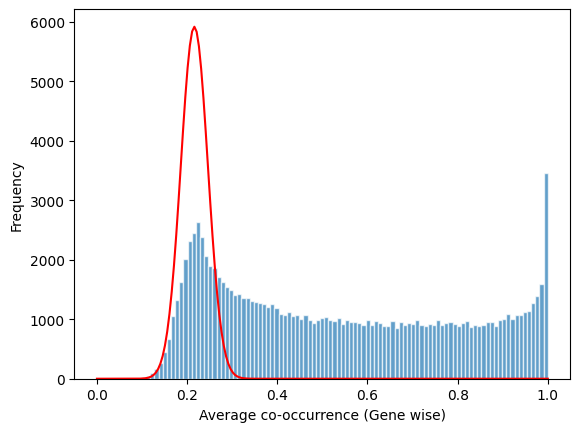

In [21]:
def gaussian(x, mu, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

x = np.linspace(0, 1, 200)
plt.plot(x, 445*gaussian(x=x, mu=0.216, sigma=0.03), color='red')

# Co-occurrence sum per gene
sum_co_occ_genes = df_co_occurrence.T.sum(1)/df_co_occurrence.shape[0]
plt.hist(sum_co_occ_genes.values, edgecolor='white', bins=100, alpha=0.7)
plt.ylabel('Frequency')
plt.xlabel('Average co-occurrence (Gene wise)')
#plt.yscale('log')
plt.show()

### Both

In [22]:
occ_genes = ((df_genes>0).sum(0)/df_genes.shape[0]).loc[sum_co_occ_genes.index]

both = sum_co_occ_genes * occ_genes

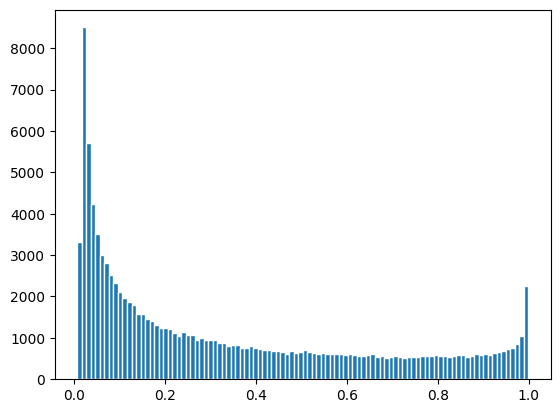

In [23]:
plt.hist(both.sort_values(ascending=False), bins=100, edgecolor='white')
plt.show()

## Relation Between Co-Occurrence and Occurrence

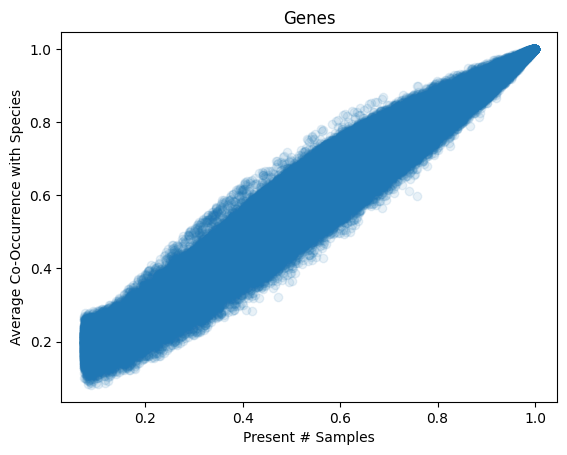

In [24]:
plt.scatter((df_genes.loc[:, (df_genes > 0).sum(0) >= threshold]>0).sum(0)/df_genes.shape[0],
            sum_co_occ_genes,
            alpha=0.1)
plt.xlabel('Present # Samples')
plt.ylabel('Average Co-Occurrence with Species')

plt.title('Genes')

plt.show()

# Samples

## Cosine Similarity

In [25]:
print(f'{int(0.5*df_taxon.shape[0]**2) - df_taxon.shape[0]} Operations')

df_taxon = df_taxon.loc[df_genes.index]
# (df_taxon.index == df_genes.index).sum() == df_taxon.shape[0] # sanity check

3615360 Operations


### Sample-Cluster Centroid

We should check if the cluster similarity from generating the genes has influence on the distance distribution to the centroid

In [26]:
# compute distance distribution
df_taxon_tensor = torch.tensor(df_taxon.values, dtype=torch.float32, device=device)
df_genes_tensor = torch.tensor(df_genes.values, dtype=torch.float32, device=device)

taxon_centroid = df_taxon_tensor.mean(dim=0, keepdim=True)
genes_centroid = df_genes_tensor.mean(dim=0, keepdim=True)

cos_sim_taxon = torch.nn.functional.cosine_similarity(df_taxon_tensor, taxon_centroid, dim=1)
cos_sim_genes = torch.nn.functional.cosine_similarity(df_genes_tensor, genes_centroid, dim=1)

cos_sim_taxon_cpu = cos_sim_taxon.cpu().numpy()
cos_sim_genes_cpu = cos_sim_genes.cpu().numpy()

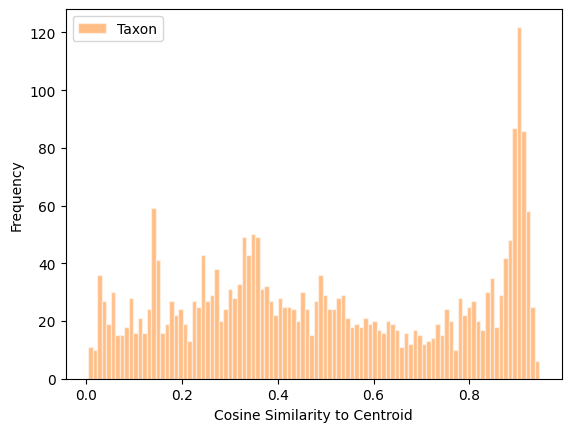

In [27]:
plt.hist(cos_sim_taxon_cpu, color='C1', label='Taxon', alpha=0.5, edgecolor='white', bins=100)
# plt.hist(cos_sim_genes_cpu, color='C0', label='Genes', alpha=0.5, edgecolor='white', bins=100)
plt.xlabel('Cosine Similarity to Centroid')
plt.ylabel('Frequency')
plt.legend()
plt.show()

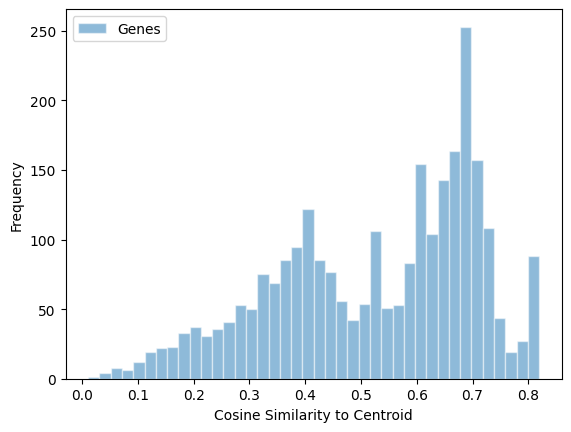

In [28]:
#plt.hist(cos_sim_taxon_cpu, color='C1', label='Taxon', alpha=0.5, edgecolor='white', bins=30)
plt.hist(cos_sim_genes_cpu, color='C0', label='Genes', alpha=0.5, edgecolor='white', bins=40)
plt.xlabel('Cosine Similarity to Centroid')
plt.ylabel('Frequency')
plt.legend()
plt.show()

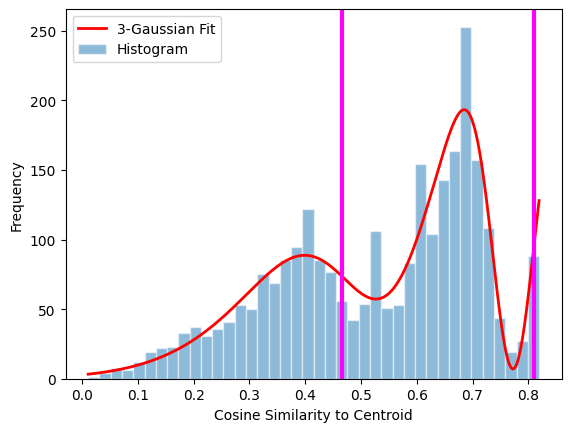

In [49]:
def three_gaussians(x, A1, mu1, sigma1, A2, mu2, sigma2, A3, mu3, sigma3):
    return (
        A1 * np.exp(-((x - mu1) ** 2) / (2 * sigma1 ** 2)) +
        A2 * np.exp(-((x - mu2) ** 2) / (2 * sigma2 ** 2)) +
        A3 * np.exp(-((x - mu3) ** 2) / (2 * sigma3 ** 2))
    )

# histogram
bins = 40
hist_vals, bin_edges = np.histogram(cos_sim_genes_cpu, bins=bins, density=False)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  

# initial parametres
p0 = [max(hist_vals), 0.25, 1, max(hist_vals), 0.55, 0.5, max(hist_vals), 0.75, 0.05]

popt, _ = curve_fit(three_gaussians, bin_centers, hist_vals, p0=p0, maxfev = 2000000)

x_fit = np.linspace(bin_edges[0], bin_edges[-1], 500)
y_fit = three_gaussians(x_fit, *popt)

plt.bar(bin_centers, hist_vals, width=(bin_edges[1] - bin_edges[0]), alpha=0.5, label="Histogram", edgecolor='white')
plt.plot(x_fit, y_fit, color='red', linewidth=2, label="3-Gaussian Fit")
plt.axvline(x=popt[1] - abs(popt[2])    , color='magenta', linewidth=3)  
plt.axvline(x=popt[-2] + abs(popt[-1]), color='magenta', linewidth=3) 
plt.xlabel("Cosine Similarity to Centroid")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [50]:
popt # A1, mu1, sigma1, A2, mu2, sigma2, A3, mu3, sigma3

array([ 2.96973537e+02,  6.93370403e-01,  2.27150018e-01, -1.84473751e+02,
        5.65579723e-01, -9.49052182e-02, -2.55339741e+02,  7.72270438e-01,
        3.85975850e-02])

In [51]:
boundary_1 = popt[1] + abs(popt[2])    
boundary_2 = popt[-2] + 3*abs(popt[-1])

cluster_1 = df_genes.index[cos_sim_genes_cpu < boundary_1]  
cluster_2 = df_genes.index[(cos_sim_genes_cpu >= boundary_1) & (cos_sim_genes_cpu <= boundary_2)] 
cluster_3 = df_genes.index[cos_sim_genes_cpu > boundary_2]  

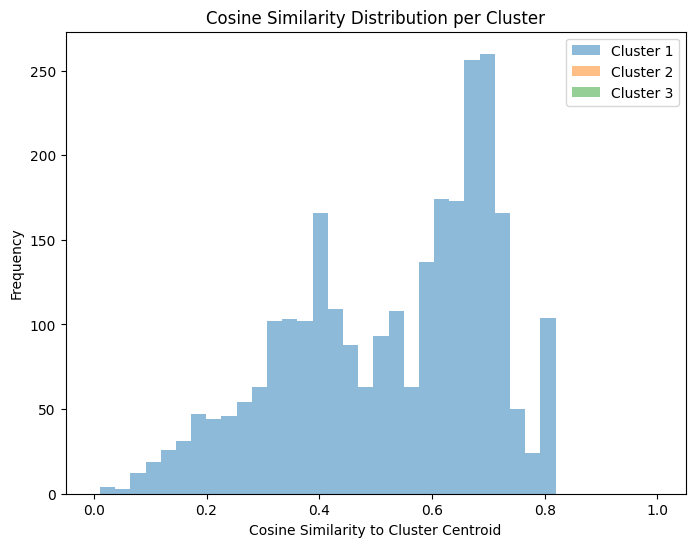

In [52]:
# Convert df_genes to a tensor
df_genes_tensor = torch.tensor(df_genes.values, dtype=torch.float32, device=device)

# Get indices for each cluster
cluster_1_indices = df_genes.index.isin(cluster_1)
cluster_2_indices = df_genes.index.isin(cluster_2)
cluster_3_indices = df_genes.index.isin(cluster_3)

# Extract tensors for each cluster
cluster_1_tensor = df_genes_tensor[cluster_1_indices]
cluster_2_tensor = df_genes_tensor[cluster_2_indices]
cluster_3_tensor = df_genes_tensor[cluster_3_indices]

# Compute centroids for each cluster
cluster_1_centroid = cluster_1_tensor.mean(dim=0, keepdim=True)
cluster_2_centroid = cluster_2_tensor.mean(dim=0, keepdim=True)
cluster_3_centroid = cluster_3_tensor.mean(dim=0, keepdim=True)

# Compute cosine similarity for each gene in the cluster to its cluster centroid
cos_sim_cluster_1 = torch.nn.functional.cosine_similarity(cluster_1_tensor, cluster_1_centroid, dim=1).cpu().numpy()
cos_sim_cluster_2 = torch.nn.functional.cosine_similarity(cluster_2_tensor, cluster_2_centroid, dim=1).cpu().numpy()
cos_sim_cluster_3 = torch.nn.functional.cosine_similarity(cluster_3_tensor, cluster_3_centroid, dim=1).cpu().numpy()

# Plot histogram with the three clusters
plt.figure(figsize=(8, 6))
plt.hist(cos_sim_cluster_1, bins=30, alpha=0.5, label="Cluster 1")
plt.hist(cos_sim_cluster_2, bins=30, alpha=0.5, label="Cluster 2")
plt.hist(cos_sim_cluster_3, bins=30, alpha=0.5, label="Cluster 3")

# Labels and legend
plt.xlabel("Cosine Similarity to Cluster Centroid")
plt.ylabel("Frequency")
plt.legend()
plt.title("Cosine Similarity Distribution per Cluster")
plt.show()

## Dendogram (samples - Gene vectors)

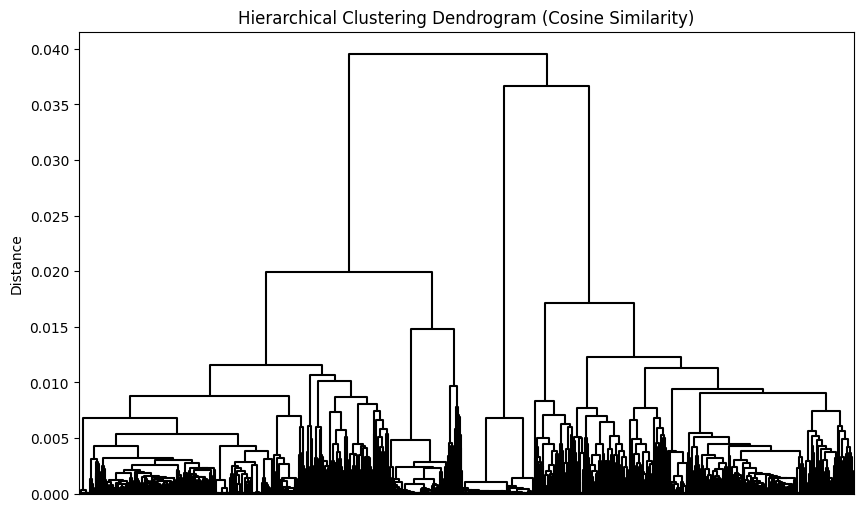

In [33]:
# Convert df_genes to a tensor (samples = rows, genes = columns)
df_genes_tensor = torch.tensor(df_genes.values, dtype=torch.float32, device=device)

# Normalize the rows (samples) for cosine similarity computation
df_genes_normalized = df_genes_tensor / df_genes_tensor.norm(dim=1, keepdim=True)

# Compute cosine similarity using matrix multiplication (efficient!)
cos_sim_matrix = torch.mm(df_genes_normalized, df_genes_normalized.T)

# Convert similarity to distance (1 - similarity)
cos_dist_matrix = 1 - cos_sim_matrix

# Convert to NumPy for hierarchical clustering (detach from PyTorch if needed)
cos_dist_matrix_np = cos_dist_matrix.cpu().numpy()

# Convert to condensed form for hierarchical clustering
condensed_dist_matrix = sch.distance.pdist(cos_dist_matrix_np, metric="cosine")

# Perform hierarchical clustering using average linkage
linkage_matrix = sch.linkage(condensed_dist_matrix, method="average")

# Plot the dendrogram
plt.figure(figsize=(10, 6))
sch.dendrogram(
    linkage_matrix, 
    no_labels=True,         # Removes labels from x-axis
    color_threshold=np.inf, # Forces single color for all branches
    above_threshold_color="black", # Choose a single color (e.g., black)
    link_color_func=lambda k: "black" # Ensures all links are black
)
plt.title("Hierarchical Clustering Dendrogram (Cosine Similarity)")
plt.xlabel("")  # Remove x-axis label
plt.ylabel("Distance")
plt.xticks([])  # Hide x-tick labels
plt.show()

### Sample-Sample

In [34]:
threshold = None

if threshold: # makes no difference for cosine similarity plot
    df_taxon = df_taxon.loc[:, count_taxon >= threshold]
    df_genes = df_genes.loc[:, count_genes >= threshold]

# taxon similarity
print('Generating taxon similarity matrix...')
taxon_cosine_sim_matrix = pd.DataFrame(
    cosine_similarity(df_taxon), 
    index=df_taxon.index,
    columns=df_taxon.index
)

# genes similarity
print('Generating genes similarity matrix...')
genes_cosine_sim_matrix = pd.DataFrame(
    cosine_similarity(df_genes),
    index=df_genes.index,
    columns=df_genes.index
)

Generating taxon similarity matrix...
Generating genes similarity matrix...


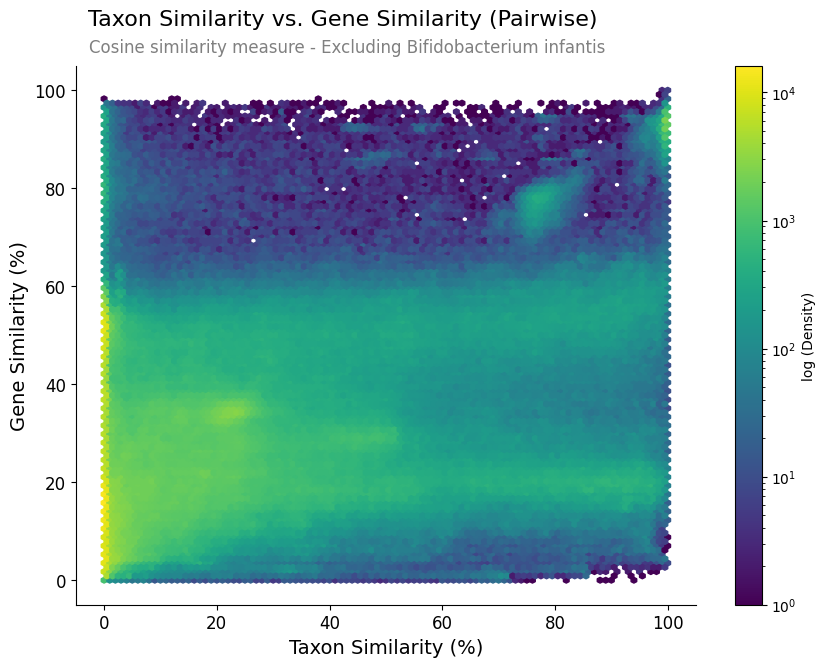

In [35]:
# Extract upper triangle values (excluding diagonal)
taxon_vals = taxon_cosine_sim_matrix.where(np.triu(np.ones(taxon_cosine_sim_matrix.shape), k=1).astype(bool)).stack()
genes_vals = genes_cosine_sim_matrix.where(np.triu(np.ones(genes_cosine_sim_matrix.shape), k=1).astype(bool)).stack()

plt.figure(figsize=(10, 7))
hb = plt.hexbin(
    taxon_vals * 100, genes_vals * 100, gridsize=100, cmap='viridis', bins='log'
)

cb = plt.colorbar(label='log (Density)')

plt.xlabel('Taxon Similarity (%)', fontsize=14)
plt.ylabel('Gene Similarity (%)', fontsize=14)
plt.title('Taxon Similarity vs. Gene Similarity (Pairwise)', fontsize=16, x=0.43, y=1.06)
plt.suptitle('Cosine similarity measure - Excluding Bifidobacterium infantis', fontsize=12, color='gray', x=0.396, y=0.92)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

plt.show()

## Similarity as Taxon granularity decreases

Generating taxon similarity matrix...


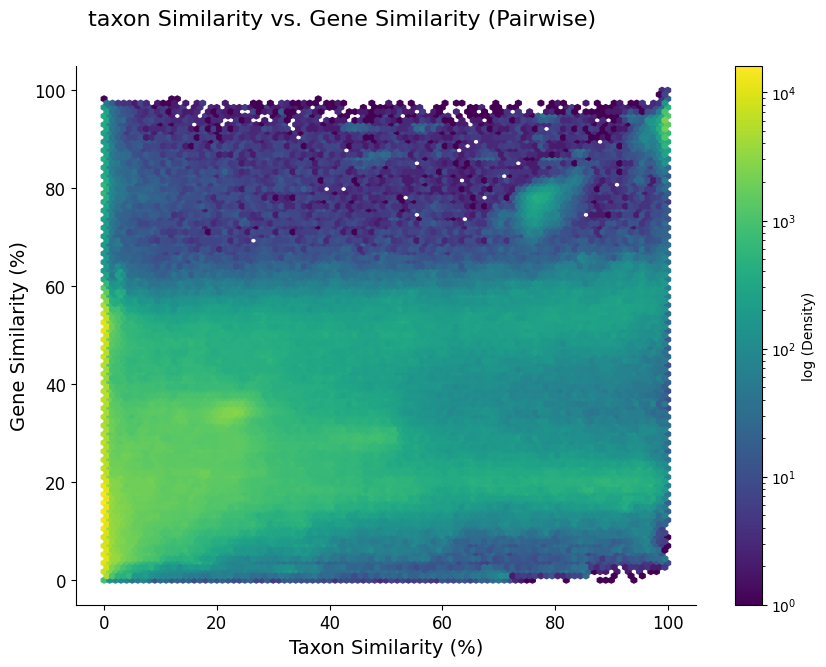

Generating taxon similarity matrix...


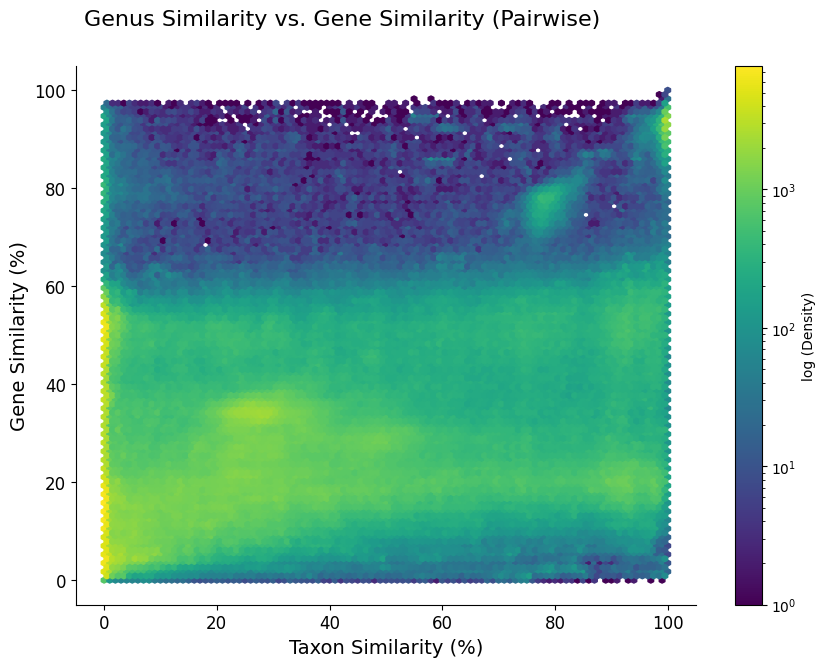

Generating taxon similarity matrix...


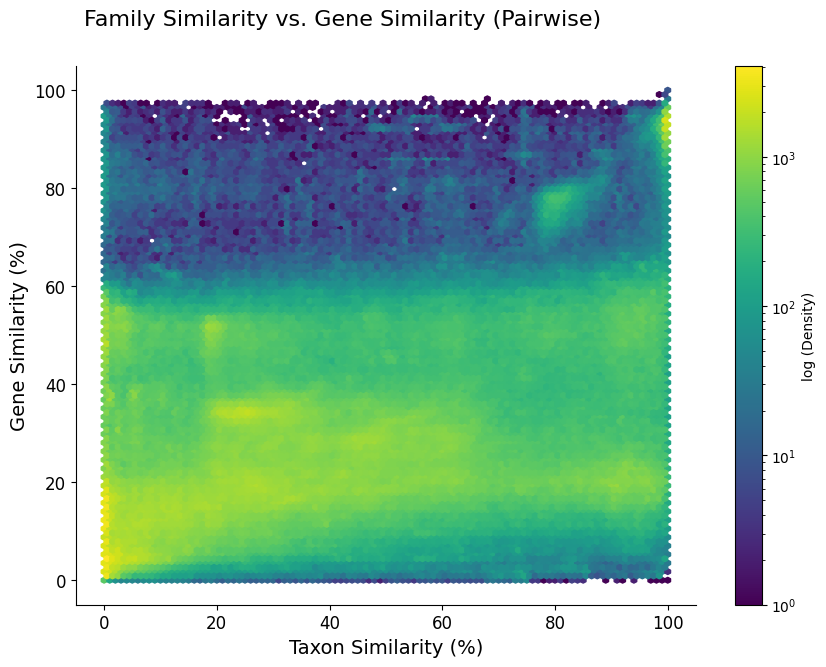

Generating taxon similarity matrix...


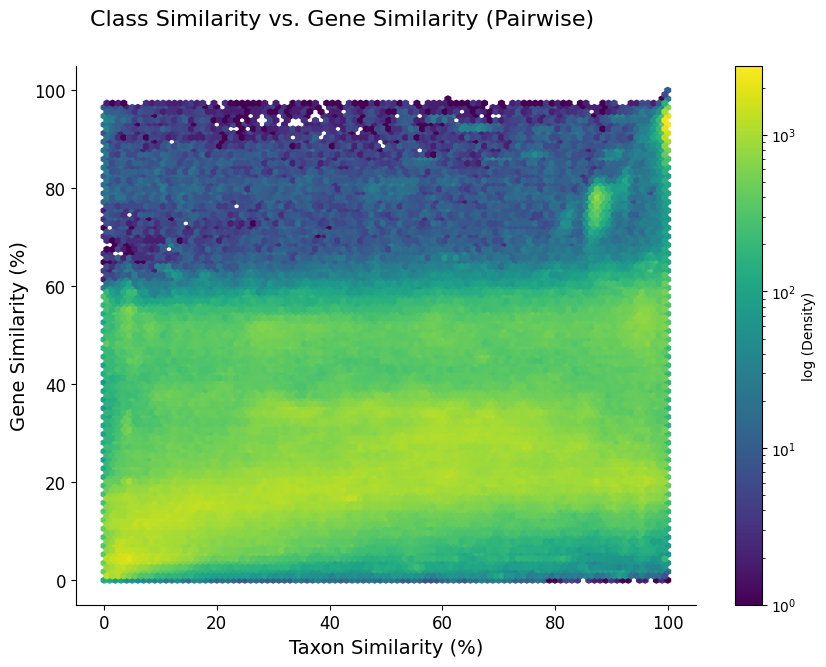

Generating taxon similarity matrix...


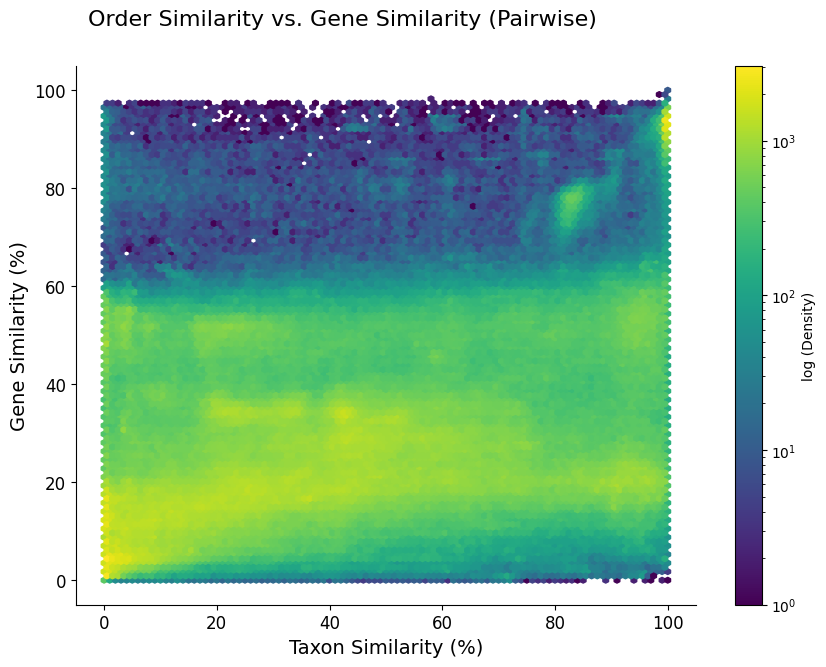

Generating taxon similarity matrix...


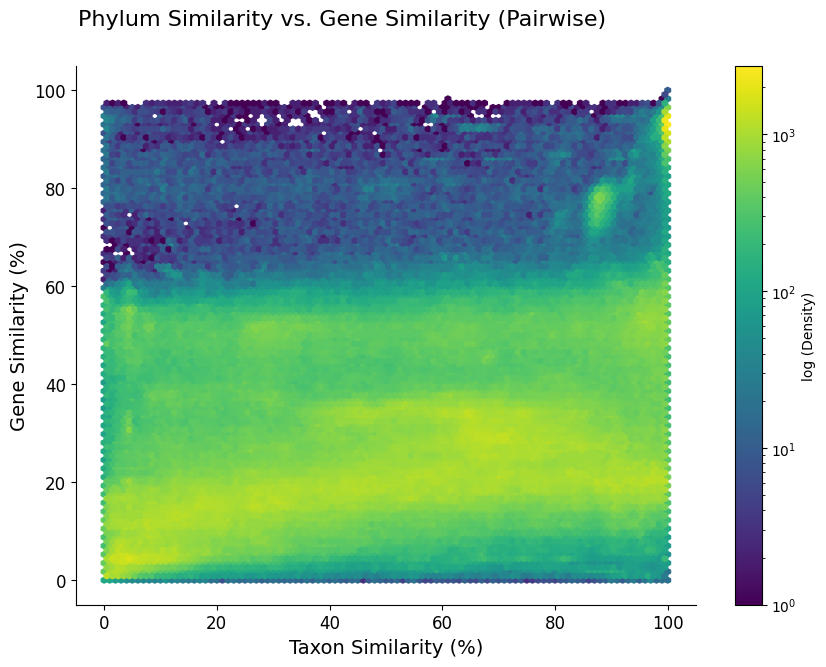

In [36]:
taxons = ['s', 'g', 'f', 'c', 'o', 'p']

taxon_name = {'s': 'taxon',
              'g': 'Genus',
              'f': 'Family',
              'o': 'Order',
              'c': 'Class',
              'p': 'Phylum'}

for taxon in taxons:
    df_taxon = pd.read_parquet(f'../processed_data/taxon_coverage_{taxon}.parquet')
    df_taxon = df_taxon.loc[df_genes.index]

    # taxon similarity
    print('Generating taxon similarity matrix...')
    taxon_cosine_sim_matrix = pd.DataFrame(
    cosine_similarity(df_taxon), 
    index=df_taxon.index,
    columns=df_taxon.index
)
    # Extract upper triangle values (excluding diagonal)
    taxon_vals = taxon_cosine_sim_matrix.where(np.triu(np.ones(taxon_cosine_sim_matrix.shape), k=1).astype(bool)).stack()
    genes_vals = genes_cosine_sim_matrix.where(np.triu(np.ones(genes_cosine_sim_matrix.shape), k=1).astype(bool)).stack()
    
    plt.figure(figsize=(10, 7))
    hb = plt.hexbin(
        taxon_vals * 100, genes_vals * 100, gridsize=100, cmap='viridis', bins='log'
    )
    
    cb = plt.colorbar(label='log (Density)')
    
    plt.xlabel('Taxon Similarity (%)', fontsize=14)
    plt.ylabel('Gene Similarity (%)', fontsize=14)
    plt.title(f'{taxon_name[taxon]} Similarity vs. Gene Similarity (Pairwise)', fontsize=16, x=0.43, y=1.06)
    # plt.suptitle('Cosine similarity measure - Excluding Bifidobacterium infantis', fontsize=12, color='gray', x=0.396, y=0.92)
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    for spine in ['top', 'right']:
        plt.gca().spines[spine].set_visible(False)

    plt.savefig(f'plots/{taxon_name[taxon]}.png')
    
    plt.show()

### Generating uniform random Taxon

In [37]:
print('Generating uniform random taxon similarity matrix...')
taxon_cosine_sim_matrix = pd.DataFrame(
    np.random.uniform(low=0, high=1, size=(len(df_taxon), len(df_taxon))),
    index=df_taxon.index,
    columns=df_taxon.index
)

taxon_cosine_sim_matrix = (taxon_cosine_sim_matrix + taxon_cosine_sim_matrix.T) / 2
np.fill_diagonal(taxon_cosine_sim_matrix.values, 1.0)

Generating uniform random taxon similarity matrix...


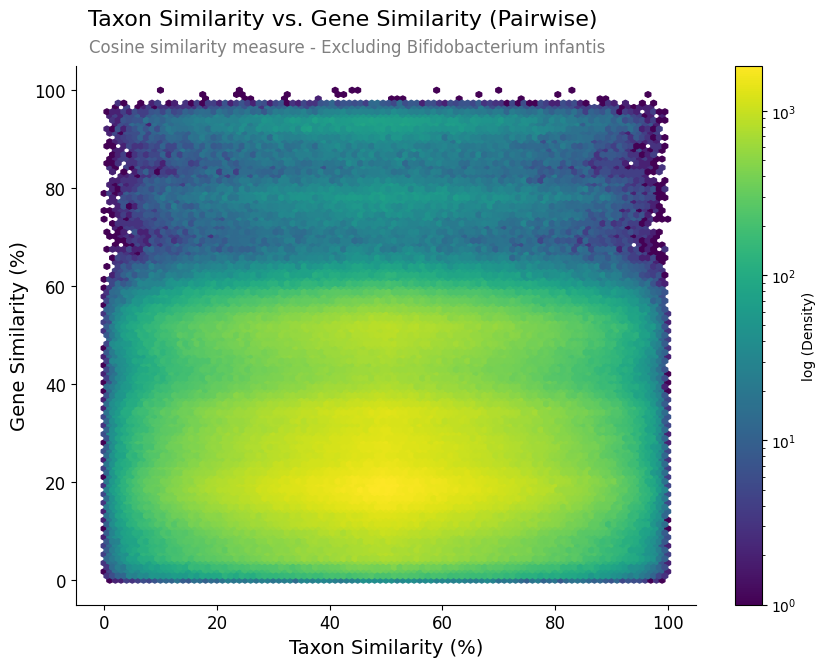

In [38]:
# Extract upper triangle values (excluding diagonal)
taxon_vals = taxon_cosine_sim_matrix.where(np.triu(np.ones(taxon_cosine_sim_matrix.shape), k=1).astype(bool)).stack()
genes_vals = genes_cosine_sim_matrix.where(np.triu(np.ones(genes_cosine_sim_matrix.shape), k=1).astype(bool)).stack()

plt.figure(figsize=(10, 7))
hb = plt.hexbin(
    taxon_vals * 100, genes_vals * 100, gridsize=100, cmap='viridis', bins='log'
)

cb = plt.colorbar(label='log (Density)')

plt.xlabel('Taxon Similarity (%)', fontsize=14)
plt.ylabel('Gene Similarity (%)', fontsize=14)
plt.title('Taxon Similarity vs. Gene Similarity (Pairwise)', fontsize=16, x=0.43, y=1.06)
plt.suptitle('Cosine similarity measure - Excluding Bifidobacterium infantis', fontsize=12, color='gray', x=0.396, y=0.92)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

plt.show()

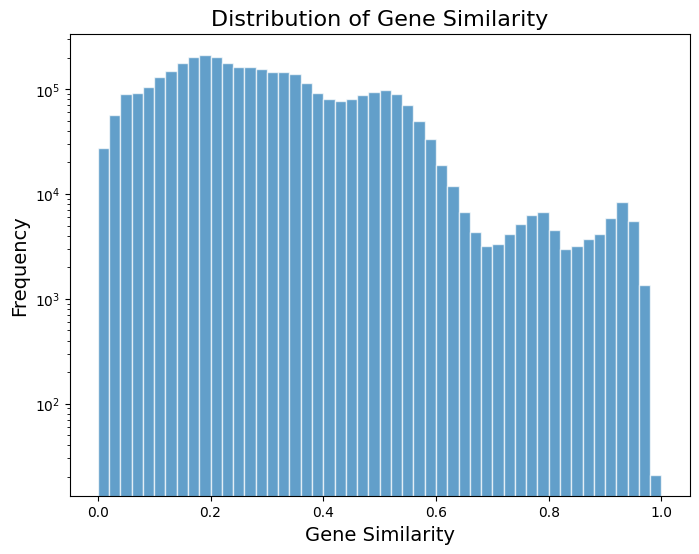

In [39]:
plt.figure(figsize=(8, 6))
plt.hist(genes_vals, bins=50, alpha=0.7, edgecolor='white')

plt.xlabel('Gene Similarity', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Gene Similarity', fontsize=16)

plt.yscale('log')

plt.show()

Generating taxon similarity matrix...


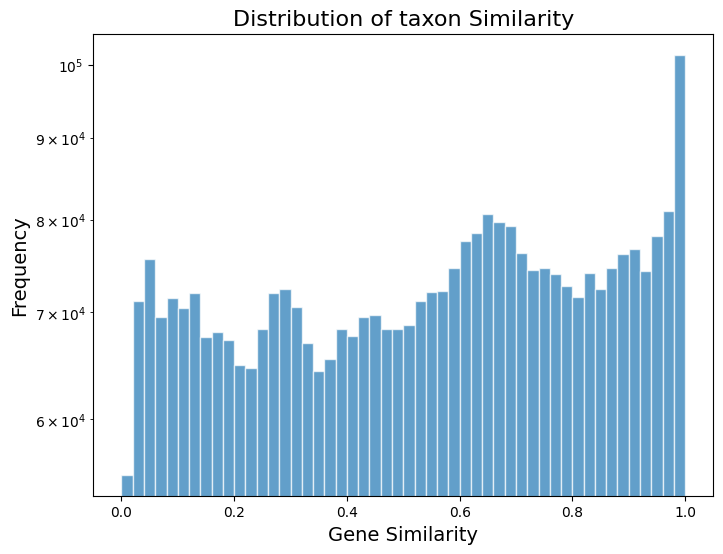

In [40]:
# taxon similarity
print('Generating taxon similarity matrix...')
taxon_cosine_sim_matrix = pd.DataFrame(
    cosine_similarity(df_taxon), 
    index=df_taxon.index,
    columns=df_taxon.index
)

taxon_vals = taxon_cosine_sim_matrix.where(np.triu(np.ones(taxon_cosine_sim_matrix.shape), k=1).astype(bool)).stack()

plt.figure(figsize=(8, 6))
plt.hist(taxon_vals, bins=50, alpha=0.7, edgecolor='white')

plt.xlabel('Gene Similarity', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of taxon Similarity', fontsize=16)

plt.yscale('log')

plt.show()

# Mutual Information (Are the variables independent)

In [41]:
mi = mutual_info_regression(taxon_vals.values.reshape(-1, 1), genes_vals.values)[0] # not simmetric

print("Mutual Information:", mi)

Mutual Information: 0.10845840057586464


In [42]:
'''
Mutual Information (MI) as Conditional Entropy:

MI(X, Y) = H(X) - H(X | Y)

Where:
- H(X) = -∫ p(X) log p(X) dX  # Entropy of gene similarity (X)
- H(X | Y) = -∫∫ p(X, Y) log p(X | Y) dX dY  # Conditional entropy of X given Y

X = genes_vals_filtered.values  # Gene similarity values (continuous random variable)
Y = taxon_vals.values.reshape(-1, 1)  # Taxon similarity values (continuous random variable)
'''

'\nMutual Information (MI) as Conditional Entropy:\n\nMI(X, Y) = H(X) - H(X | Y)\n\nWhere:\n- H(X) = -∫ p(X) log p(X) dX  # Entropy of gene similarity (X)\n- H(X | Y) = -∫∫ p(X, Y) log p(X | Y) dX dY  # Conditional entropy of X given Y\n\nX = genes_vals_filtered.values  # Gene similarity values (continuous random variable)\nY = taxon_vals.values.reshape(-1, 1)  # Taxon similarity values (continuous random variable)\n'

Processing threshold: 1.0 ...
removed 0 genes.
Mutual Information at threshold 1.0: 0.10845838245268347
Processing threshold: 0.9689655172413794 ...
removed 6008 genes.
Mutual Information at threshold 0.9689655172413794: 0.1044020952876421
Processing threshold: 0.9379310344827586 ...
removed 9548 genes.
Mutual Information at threshold 0.9379310344827586: 0.10336068396750786
Processing threshold: 0.906896551724138 ...
removed 12705 genes.
Mutual Information at threshold 0.906896551724138: 0.10197556476869973
Processing threshold: 0.8758620689655172 ...
removed 15689 genes.
Mutual Information at threshold 0.8758620689655172: 0.10274350319709846
Processing threshold: 0.8448275862068966 ...
removed 18573 genes.
Mutual Information at threshold 0.8448275862068966: 0.10278195247584865
Processing threshold: 0.8137931034482759 ...
removed 21278 genes.
Mutual Information at threshold 0.8137931034482759: 0.1050896720500134
Processing threshold: 0.7827586206896552 ...
removed 24005 genes.
Mutual I

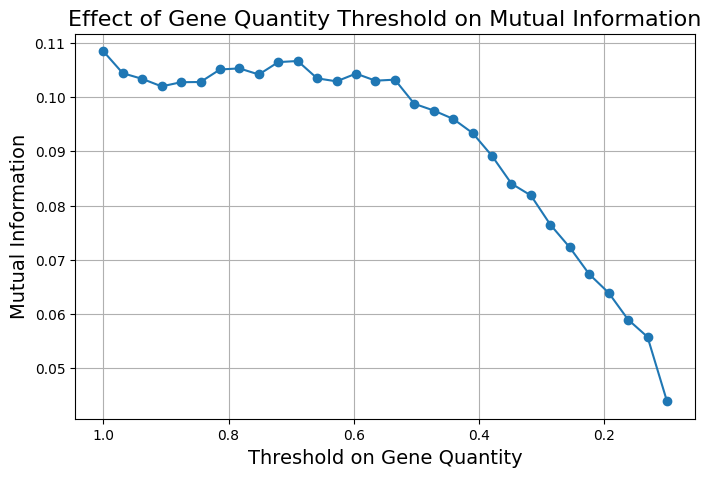

In [43]:
# Define the thresholds
thresholds = np.linspace(1, 0.1, 30)

df_gene_counts = (df_genes>0).sum(0)/df_genes.shape[0]

# Store results
mi_values = []

for threshold in thresholds:
    print(f"Processing threshold: {threshold} ...")

    # Step 1: Filter genes (columns) based on the threshold
    filtered_genes = df_gene_counts[df_gene_counts <= threshold].index  # Genes to keep
    df_genes_filtered = df_genes.loc[:, filtered_genes]  # Keep all samples, only selected genes

    print(f'removed {int(df_genes.shape[1] - len(filtered_genes))} genes.')

    # Step 2: Compute new gene similarity matrix (samples x samples)
    genes_cosine_sim_matrix = pd.DataFrame(
        cosine_similarity(df_genes_filtered),
        index=df_genes.index,  # Keep sample index
        columns=df_genes.index # Keep sample index
    )

    # Step 3: Extract upper triangle values (excluding diagonal)
    genes_vals_filtered = genes_cosine_sim_matrix.where(
        np.triu(np.ones(genes_cosine_sim_matrix.shape), k=1).astype(bool)
    ).stack()

    # Step 4: Compute Mutual Information
    mi = mutual_info_regression(taxon_vals.values.reshape(-1, 1), genes_vals_filtered.values)[0]
    mi_values.append(mi)

    print(f"Mutual Information at threshold {threshold}: {mi}")

# Step 5: Plot MI vs. Threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, mi_values, marker='o', linestyle='-')
plt.xlabel("Threshold on Gene Quantity", fontsize=14)
plt.ylabel("Mutual Information", fontsize=14)
plt.title("Effect of Gene Quantity Threshold on Mutual Information", fontsize=16)
plt.gca().invert_xaxis()  # Higher thresholds mean fewer genes, so flip x-axis for clarity
plt.grid(True)
plt.show()

In [44]:
# Se calhar posso olhar para as quebras. 
# Onde há maiores quebras quer dizer que os genes remomvidos são oos que estão mais relacionados com as espécies presentes???








In [45]:
# Sanity Check
test = pd.DataFrame({'G1': [1, 0, 1], 'G2': [0, 1, 1], 'G3':[0, 0, 1]})
test.index = ['S1', 'S2', 'S3']

print(test)
print('\n----------\n')

sim_matrix = pd.DataFrame(cosine_similarity(test))

print(sim_matrix.where(np.triu(np.ones(sim_matrix.shape), k=1).astype(bool)).stack())

    G1  G2  G3
S1   1   0   0
S2   0   1   0
S3   1   1   1

----------

0  1    0.00000
   2    0.57735
1  2    0.57735
dtype: float64


# Dimentionality Reduction